### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [38]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2020.csv')
df = df.iloc[::5, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [39]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [40]:
df.head()

,year,Post
0,2020,"It’s Wednesday, And I’m Dreading Going Back To..."
5,2020,"Ode to My Overgrown EyebrowsAs a child, I took..."
10,2020,A story to change your perspective about what ...
15,2020,"100 days to overcome depression, chronic pain ..."
20,2020,Dance. Diego. Lizzo.I didn’t start the year in...


In [41]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [42]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [43]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['it', 'wednesday', 'and', 'dreading', 'going', 'back', 'to', 'worki', 'like', 'my', 'job', 'but', 'also', 'think', 've', 'never', 'quite', 'dreaded', 'job', 'as', 'much', 'as', 'sometimes', 'dread', 'this', 'one', 'remember', 'when', 'worked', 'at', 'the', 'gym', 'was', 'saying', 'to', 'coworker', 'one', 'day', 'it', 'really', 'hard', 'to', 'find', 'job', 'you', 'don', 'dread', 'coming', 'to', 'every', 'day', 'or', 'that', 'you', 'don', 'feel', 'like', 'you', 'need', 'to', 'take', 'time', 'away', 'from', 'and', 'that', 'what', 'it', 'was', 'like', 'to', 'work', 'there', 'here', 'sometimes', 'dread', 'going', 'and', 'often', 'feel', 'like', 'might', 'need', 'to', 'take', 'time', 'away', 'because', 'can', 'feel', 'the', 'stress', 'getting', 'to', 'me', 'those', 'were', 'pretty', 'few', 'and', 'far', 'between', 'though', 'which', 'is', 'good', 'because', 'wasn', 'even', 'in', 'program', 'that', 'would', 'warrant', 'such', 'stress', 'didn', 'study', 'law', 'wasn', 'pre', 'med', 'studied'

In [44]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [45]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [46]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['it', 'wednesday', 'and', 'dreading', 'going', 'back', 'to', 'worki', 'like', 'my', 'job', 'but', 'also', 'think', 've', 'never', 'quite', 'dreaded', 'job', 'as', 'much', 'as', 'sometimes', 'dread', 'this', 'one', 'remember', 'when', 'worked', 'at', 'the', 'gym', 'was', 'saying', 'to', 'coworker', 'one', 'day', 'it', 'really', 'hard', 'to', 'find', 'job', 'you', 'don', 'dread', 'coming', 'to', 'every', 'day', 'or', 'that', 'you', 'don', 'feel', 'like', 'you', 'need', 'to', 'take', 'time', 'away', 'from', 'and', 'that', 'what', 'it', 'was', 'like', 'to', 'work', 'there', 'here', 'sometimes', 'dread', 'going', 'and', 'often', 'feel', 'like', 'might', 'need', 'to', 'take', 'time', 'away', 'because', 'can', 'feel', 'the', 'stress', 'getting', 'to', 'me', 'those', 'were', 'pretty', 'few', 'and', 'far', 'between', 'though', 'which', 'is', 'good', 'because', 'wasn', 'even', 'in', 'program', 'that', 'would', 'warrant', 'such', 'stress', 'didn', 'study', 'law', 'wasn', 'pre', 'med', 'studied',

In [47]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [48]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [55]:
# data_words_nostops = remove_stopwords(data_words)
# print("1")
# data_words_bigrams = make_bigrams(data_words_nostops)
# print("2")

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print("3")

# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)
# print("4")

# # 3. Create Corpus
# texts = data_lemmatized

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)
# print("5")

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# print("6")
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# print("7")
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
# print("8")

# # 6. Filter out least frequently used words
# no_below = 0.02
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)
# print("9")

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
# print("10")

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)
# print("11")

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [56]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"disorder" + 0.054*"symptom" + 0.048*"therapy" + 0.038*"treatment" + '
  '0.032*"therapist" + 0.018*"patient" + 0.017*"trigger" + 0.015*"treat" + '
  '0.015*"medical" + 0.014*"common"'),
 (1,
  '0.220*"pain" + 0.065*"suffer" + 0.050*"sadness" + 0.047*"hospital" + '
  '0.038*"sad" + 0.033*"depressed" + 0.030*"depress" + 0.029*"hide" + '
  '0.027*"suicide" + 0.026*"suffering"'),
 (2,
  '0.020*"speak" + 0.019*"music" + 0.016*"sound" + 0.013*"voice" + '
  '0.011*"wear" + 0.011*"eye" + 0.011*"car" + 0.010*"air" + 0.010*"foot" + '
  '0.010*"color"'),
 (3,
  '0.045*"negative" + 0.041*"positive" + 0.022*"energy" + 0.019*"peace" + '
  '0.019*"thinking" + 0.016*"awareness" + 0.015*"relax" + 0.015*"attention" + '
  '0.015*"listen" + 0.012*"physical"'),
 (4,
  '0.103*"panic_attack" + 0.074*"attack" + 0.071*"doctor" + 0.050*"test" + '
  '0.048*"medication" + 0.039*"panic" + 0.039*"drug" + 0.028*"medicine" + '
  '0.025*"psychiatrist" + 0.023*"disease"'),
 (5,
  '0.018*"relationship" + 

In [57]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.707777129788879


In [58]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4569760132114451


In [59]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [60]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.2868,"plan, manage, set, list, task, avoid, morning,...","[wednesday, dread, go, back, worki, job, also,..."
1,1,7.0,0.2876,"bed, dream, wake, eat, cry, light, morning, ey...","[ode, overgrown, eyebrowsa, child, grant, pluc..."
2,2,7.0,0.2664,"bed, dream, wake, eat, cry, light, morning, ey...","[story, change, perspective, find, stressfuli,..."
3,3,7.0,0.2678,"bed, dream, wake, eat, cry, light, morning, ey...","[day, overcome, depression, chronic, pain, mar..."
4,4,7.0,0.3594,"bed, dream, wake, eat, cry, light, morning, ey...","[dance, diego, lizzo, start, year, good, place..."


In [61]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.2868,"plan, manage, set, list, task, avoid, morning,...","[wednesday, dread, go, back, worki, job, also,..."
1,1,7.0,0.2876,"bed, dream, wake, eat, cry, light, morning, ey...","[ode, overgrown, eyebrowsa, child, grant, pluc..."
2,2,7.0,0.2664,"bed, dream, wake, eat, cry, light, morning, ey...","[story, change, perspective, find, stressfuli,..."
3,3,7.0,0.2678,"bed, dream, wake, eat, cry, light, morning, ey...","[day, overcome, depression, chronic, pain, mar..."
4,4,7.0,0.3594,"bed, dream, wake, eat, cry, light, morning, ey...","[dance, diego, lizzo, start, year, good, place..."
...,...,...,...,...,...
2491,2491,5.0,0.1731,"relationship, choose, action, challenge, goal,...","[freedom, modern, world, unfortunately, degree..."
2492,2492,17.0,0.3064,"exercise, reduce, study, effect, increase, foo...","[review, plant, dirty, lemon, floweri, recentl..."
2493,2493,11.0,0.1585,"book, story, watch, post, social_media, play, ...","[stay, dec, sure, tick, nickin, psyche, tell, ..."
2494,2494,11.0,0.2654,"book, story, watch, post, social_media, play, ...","[follow, posti, think, post, early, drive, int..."


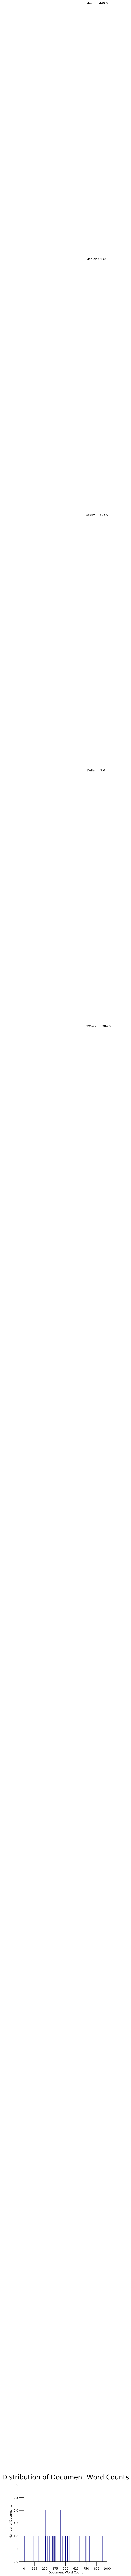

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

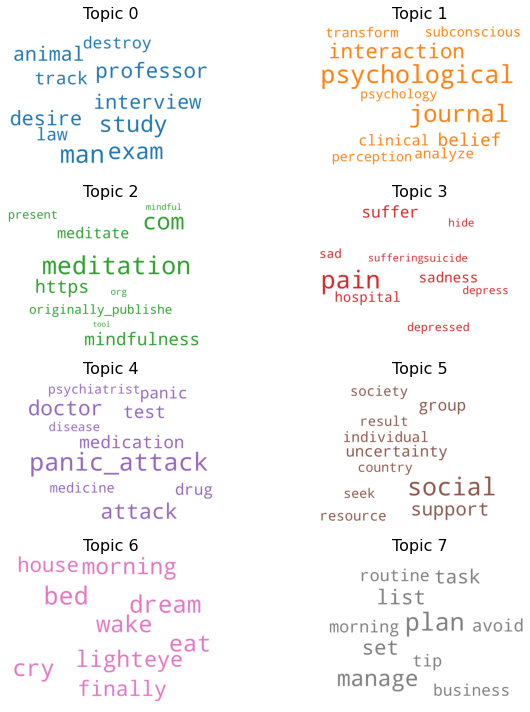

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [63]:
df_dominant_topic.to_csv("Medium2020.csv")

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=8):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=8)

(18, 0.01922878350459145, 0.3114987357694522)

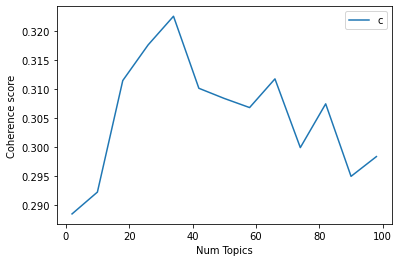

In [51]:
# Show graph
limit=100; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)